In [32]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [33]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [34]:
# Define a target distribution, p

In [35]:
tf.random.set_seed(41)

p_mu = [0.,0.]
p_L = tfb.Chain([tfb.TransformDiagonal(tfb.Softplus()),
                tfb.FillTriangular()])(tf.random.uniform([3]))

p = tfd.MultivariateNormalTriL(loc=p_mu, scale_tril=p_L)

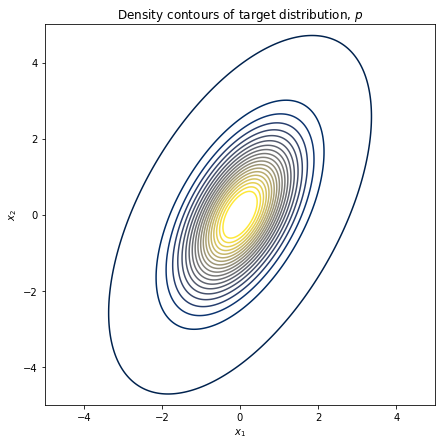

In [36]:
# Plot the target distribution's density contours

def plot_density_contours(density, X1, X2, contour_kwargs, ax=None):
    '''
        Plots the contours of a bivariate TensorFlow density function (i.e. .prob()).
        X1 and X2 are numpy arrays of mesh coordinates.
    '''
    X = np.hstack([X1.flatten()[:, np.newaxis], X2.flatten()[:, np.newaxis]])
    density_values = np.reshape(density(X).numpy(), newshape=X1.shape)
    
    if ax==None:
        _, ax = plt.subplots(figsize=(7, 7))
    
    ax.contour(X1, X2, density_values, **contour_kwargs)
    return(ax)

x1 = np.linspace(-5, 5, 1000)
x2 = np.linspace(-5, 5, 1000)
X1, X2 = np.meshgrid(x1, x2)
f, ax = plt.subplots(1, 1, figsize=(7, 7))

# Density contours are linearly spaced
contour_levels = np.linspace(1e-4, 10**(-0.8), 20) # specific to this seed
ax = plot_density_contours(p.prob, X1, X2, 
                           {'levels':contour_levels, 
                            'cmap':'cividis'}, ax=ax)
ax.set_xlim(-5, 5); ax.set_ylim(-5, 5); 
ax.set_title('Density contours of target distribution, $p$')
ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$');

We can see that the distributions components are correlated, because the density contours are tilted ellipses.

The distribution that we will using to approximate the target distribution is a bivariate normal with diagonal covariance. The components of this distribution are uncorrelated for all parameter values, meaning that it won't be possible to approximate perfectly the target density.

In [37]:
# Initialize an approximating distribution, q, that has diagonal covariance

tf.random.set_seed(41)

q = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal([2])),
                             scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]),
                                                                    bijector=tfb.Exp()))

In [38]:
# Define a function for the KL divergence

@tf.function
def loss_and_grads(dist_a, dist_b):
    with tf.GradientTape() as tape:
        loss = tfd.kl_divergence(dist_a, dist_b)
    return loss, tape.gradient(loss, dist_a.trainable_variables)

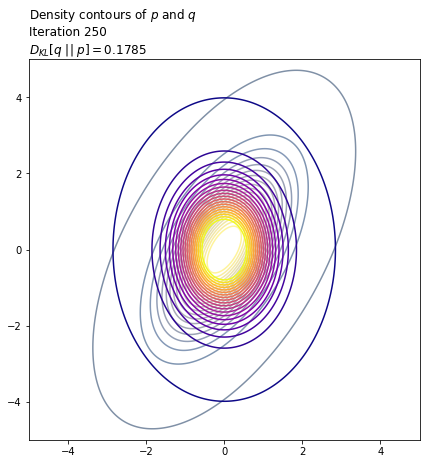

In [39]:
# Run a training loop that computes KL[q || p], updates q's parameters using its gradients

num_train_steps = 250
opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    
    # Compute the KL divergence and its gradients
    q_loss, grads = loss_and_grads(q, p)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[q \ || \ p] = ' + 
                      str(np.round(q_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)

Notice that the variance of the target distribution is being underestimated in the direction of the ellipsis major axis.

In [40]:
# Re-fit the distribution, this time fitting q_rev by minimizing KL[p || q]

tf.random.set_seed(41)

q_rev = tfd.MultivariateNormalDiag(loc=tf.Variable(tf.random.normal([2])),
                             scale_diag=tfp.util.TransformedVariable(tf.random.uniform([2]),
                                                                    bijector=tfb.Exp()))

In [41]:
# Define a function for the KL divergence

@tf.function
def loss_and_grads(dist_a, dist_b, reverse=False):
    with tf.GradientTape() as tape:
        if not reverse:
            loss = tfd.kl_divergence(dist_a, dist_b)
        else:
            loss = tfd.kl_divergence(dist_b, dist_a)
    return loss, tape.gradient(loss, dist_a.trainable_variables)

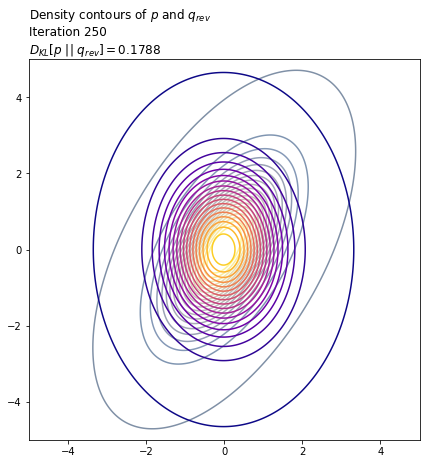

In [42]:
# Re-initialize optimizer, run training loop

opt = tf.keras.optimizers.Adam(learning_rate=.01)
for i in range(num_train_steps):
    # Reverse the KL divergence terms - compute KL[p || q_rev] 
    q_rev_loss, grads = loss_and_grads(q_rev, p, reverse=True)
    
    # Update the trainable variables using the gradients via the optimizer
    opt.apply_gradients(zip(grads, q_rev.trainable_variables))
    
    # Plot the updated density 
    if ((i + 1) % 10 == 0):
        clear_output(wait=True)
        ax = plot_density_contours(p.prob, X1, X2,
                                   {'levels':contour_levels,
                                    'cmap':'cividis', 'alpha':0.5})
        ax = plot_density_contours(q_rev.prob, X1, X2, 
                                   {'levels':contour_levels,
                                    'cmap':'plasma'}, ax=ax)
        ax.set_title('Density contours of $p$ and $q_{rev}$\n' +
                     'Iteration ' + str(i + 1) + '\n' +
                      '$D_{KL}[p \ || \ q_{rev}] = ' + 
                      str(np.round(q_rev_loss.numpy(), 4)) + '$',
                      loc='left')
        plt.pause(.01)

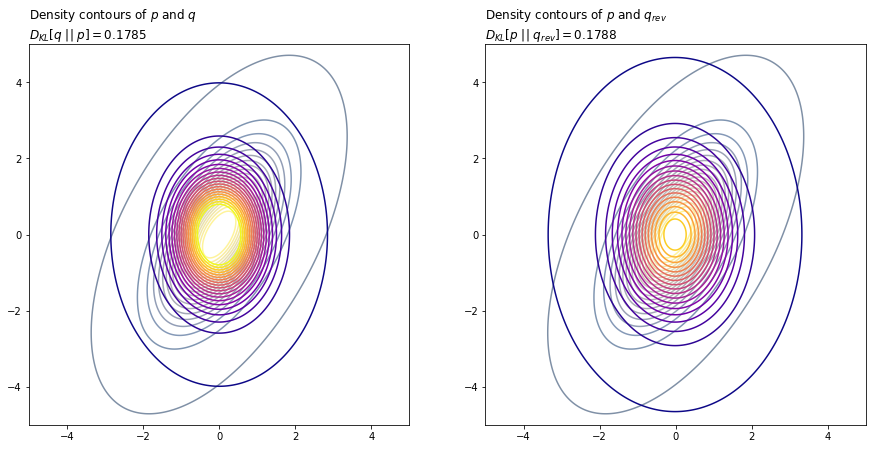

In [43]:
# Plot q and q_rev alongside one another

f, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[0])
axs[0] = plot_density_contours(q.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[0])
axs[0].set_title('Density contours of $p$ and $q$\n' +
              '$D_{KL}[q \ || \ p] = ' + str(np.round(q_loss.numpy(), 4)) + '$',
              loc='left')

axs[1] = plot_density_contours(p.prob, X1, X2,
                           {'levels':contour_levels,
                            'cmap':'cividis', 'alpha':0.5}, ax=axs[1])
axs[1] = plot_density_contours(q_rev.prob, X1, X2, 
                           {'levels':contour_levels,
                            'cmap':'plasma'}, ax=axs[1])
axs[1].set_title('Density contours of $p$ and $q_{rev}$\n' +
              '$D_{KL}[p \ || \ q_{rev}] = ' + str(np.round(q_rev_loss.numpy(), 4)) + '$',
              loc='left');

We can see that using KL(q||p) underestimates the target density dispersion, while DL(p||q_rev) is a bit more conservative but it is still not perfect.